In [ ]:
import numpy as np
import pandas as pd
import json 
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk import word_tokenize,wordpunct_tokenize,wordnet,FreqDist,PorterStemmer
from nltk.tokenize import WordPunctTokenizer
from scipy.sparse import csr_matrix

In [ ]:
path = "/content/drive/MyDrive/dataset/goodreads_reviews_spoiler.csv"

In [ ]:
chunks = pd.read_json('/content/drive/MyDrive/dataset/goodreads_reviews_spoiler.json',chunksize=5000)
df = pd.DataFrame()
for chunk in chunks:
  df = pd.concat([df,chunk])
df.to_csv(path,index=False)

In [ ]:
df = pd.read_csv(path)
df.head()

,user_id,timestamp,review_sentences,rating,has_spoiler,book_id,review_id,review_sentences_cleaned
0,8842281e1d1347389f2ab93d60773d4d,2017-08-30,"[[0, 'This is a special book.'], [0, 'It start...",5,True,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb,special bookstart slow first third middl third...
1,8842281e1d1347389f2ab93d60773d4d,2017-03-22,"[[0, 'Recommended by Don Katz.'], [0, 'Avail f...",3,False,16981,a5d2c3628987712d0e05c4f90798eb67,recommend katzavail free decemb httpwwwaudible...
2,8842281e1d1347389f2ab93d60773d4d,2017-03-20,"[[0, 'A fun, fast paced science fiction thrill...",3,True,28684704,2ede853b14dc4583f96cf5d120af636f,fun fast pace scienc fiction thrillerread nigh...
3,8842281e1d1347389f2ab93d60773d4d,2016-11-09,"[[0, 'Recommended reading to understand what i...",0,False,27161156,ced5675e55cd9d38a524743f5c40996e,recommend read understand go middl america pos...
4,8842281e1d1347389f2ab93d60773d4d,2016-04-25,"[[0, 'I really enjoyed this book, and there is...",4,True,25884323,332732725863131279a8e345b63ac33e,realli enjoy book lot recommenddrag littl end ...


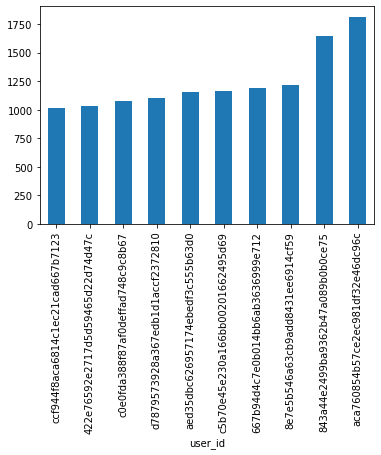

In [ ]:
df.groupby('user_id')['rating'].count().sort_values()[-10:].plot(kind='bar')


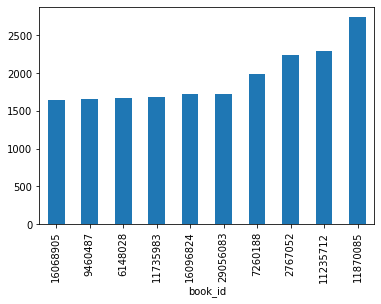

In [ ]:
df.groupby('book_id')['rating'].count().sort_values()[-10:].plot(kind='bar')


In [ ]:
df.to_csv(path,index=False)


In [ ]:
interactions_selected = X_train[['user_id',	'rating',	'book_id'	]]
factorization_matrix = pd.pivot_table(interactions_selected, index='user_id', columns='book_id', values='rating')
factorization_matrix.head()

book_id,1,2,3,5,6,11,33,34,59,104,106,112,122,151,152,153,155,208,264,295,320,343,348,350,353,356,360,365,415,428,431,537,629,656,662,667,685,703,760,816,...,35671052,35693377,35694971,35696559,35719003,35792291,35826972,35828316,35832861,35833506,35836234,35841098,35845019,35883157,35889142,35893080,35895725,35897992,35898879,35909321,35910868,35955803,35968587,35998769,36039267,36046438,36061326,36065344,36102973,36103768,36107506,36114743,36123887,36135327,36158863,36196052,36242916,36252773,36307629,36328685
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000a1016fda6008d1edbba720ca00851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000efb30c5236d7437c3cdf4bf3e4dc7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0011e1a9112b3d798702ef5b20bbf35b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0016a8010771c0c00c97f27dfc5cdd22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0019de4561419b7543238e0979f2f33e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
factorization_matrix = factorization_matrix.fillna(0)
factorization_matrix.head()

In [ ]:
factorization_matrix_csr = csr_matrix(factorization_matrix.values)



In [ ]:
model = LightFM(loss='warp',
                random_state=2016,
                learning_rate=0.90,
                no_components=20,
                user_alpha=0.000005)
model = model.fit(factorization_matrix_csr,
                  epochs=100,
                  num_threads=16, verbose=True)


Epoch: 100%|██████████| 100/100 [04:10<00:00,  2.51s/it]


In [ ]:
from lightfm.evaluation import auc_score

# Compute and print the AUC score
train_auc = auc_score(model, factorization_matrix_csr, num_threads=2).mean()
print('Collaborative filtering train AUC: %s' % train_auc)

Collaborative filtering train AUC: 0.517538


In [ ]:
!pip install surprise

In [ ]:

from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise import SVD,KNNBasic
from surprise import accuracy
from surprise.model_selection import train_test_split

reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(df[['user_id',	'book_id',	'rating'	]], reader)

In [ ]:
trainset, testset = train_test_split(data, test_size=.25)

algo = SVD()
algo.fit(trainset)
predictions = algo.test(testset)

In [ ]:
accuracy.rmse(predictions)

RMSE: 1.1153


1.1153161472898871

In [ ]:
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1144  1.1163  1.1165  1.1136  1.1124  1.1146  0.0016  
MAE (testset)     0.8382  0.8410  0.8418  0.8389  0.8382  0.8396  0.0015  
Fit time          77.58   74.85   74.54   74.89   75.30   75.43   1.10    
Test time         4.04    3.64    4.71    3.97    3.90    4.05    0.36    


{'fit_time': (77.57572746276855,
  74.85464596748352,
  74.5436041355133,
  74.88862419128418,
  75.30221247673035),
 'test_mae': array([0.83815007, 0.84102125, 0.84183262, 0.83894731, 0.83815994]),
 'test_rmse': array([1.11442876, 1.11633473, 1.1164903 , 1.11359202, 1.11237911]),
 'test_time': (4.044936418533325,
  3.643819808959961,
  4.710676431655884,
  3.970425605773926,
  3.896085739135742)}

In [ ]:
from collections import defaultdict

from surprise.model_selection import KFold

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        user_ratings.sort(key=lambda x: x[0], reverse=True)

        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])


        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls


In [ ]:
    precisions, recalls = precision_recall_at_k(predictions, k=10, threshold=2)

    print("Precision",sum(prec for prec in precisions.values()) / len(precisions))
    print("Recall",sum(rec for rec in recalls.values()) / len(recalls))

Precision 0.939761322840822
Recall 0.718993781150723
